<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/BIOSTAT615_Lecture_14_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOSTAT615 Lecture 14 - R

## 1. Simulating from a mixture of normal

This function simulates `n` independent observations from a mixture of normal.
$$p(x) = \sum_{i=1}^k \pi_k N(\mu_k, \sigma_k^2)$$

In [1]:
#' simul.dat() - simulate from a mixture of normal
#' @param n - number of observations
#' @param mu_vec - vector of means for each component
#' @param sigma_vec - vector of sds for each component
#' @param pi_vec - vector of mixing proportion 
#' @return Random sample from mixture of normal
simul.dat <- function(n,mu_vec,sigma_vec,pi_vec){
  k = length(mu_vec)
  stopifnot( k == length(sigma_vec) && k == length(pi_vec) ) 
  cluster = sample(1:k,n,prob=pi_vec,replace=TRUE)  ## sample components
  dat = rnorm(n) * sigma_vec[cluster] + mu_vec[cluster] ## random sampling
  return(dat)
}

## 2. Setting up an E-M algorithm

We will use `R`'s class features to organize the information across multiple functions. This is a useful (but not essential) R skill to learn.

In [2]:
#' Create a class normMixEM
normMixEm <- setRefClass("normMixEM",
                         fields=list(k = "integer",
                                     n = "integer",
                                     dat_vec = "vector",
                                     pi_vec = "vector",
                                     mu_vec = "vector",
                                     sigma_vec = "vector",
                                     prob_mat = "matrix",
                                     loglik = "numeric",
                                     tol = "numeric"))

To define member functions in R's class, you can utilize the following examples.

In [3]:
#' method to initialize normMixEm class (called with normMixEm$new)
#' @param input_data - data to initalize
#' @param num_components - number of components (k)
normMixEm$methods(initialize = function(input_dat,num_components){
  dat_vec <<- input_dat ## Use <<- to assign fields
  k <<- num_components
  n <<- length(dat_vec)
})

In [4]:
#' method to initialize parameters for E-M
normMixEm$methods(init.paras = function(){
  tol <<- 1e-100  ## small number to avoid log(zero) 
  pi_vec <<- rep(1.0/k,length=k)  ## uniform across components
  ## pick means from equal-spaced quantiles from the data
  mu_vec <<- quantile(dat_vec,prob=seq(1/(2*k),1-1/(2*k),length=k))
  sigma_vec <<- rep(sd(dat_vec),length=k) ## same variance
  prob_mat <<- matrix(NA,nrow=n,ncol=k)
  loglik <<- -Inf
})


## 3. Implementation of E-step

E-step calculates 

$$\Pr(z_i=j|x_i,\pi,\mu,\sigma) = \frac{\pi_j\mathcal{N}(x_i|\mu_j,\sigma_j^2)} {\sum_{k}\pi_k\mathcal{N}(x_i|\mu_k,\sigma_k^2)}$$

In [5]:
  #' E-step for E-M algorithm
  normMixEm$methods(update.prob = function(){
    ## prob_mat contains log-likelihood of each components
    prob_mat <<- sapply(1:k, function(j) 
        log(pi_vec[j]+tol)+dnorm(dat_vec,mean=mu_vec[j],sd=sigma_vec[j],log=TRUE))
    max_log_prob <- apply(prob_mat,1,max) ## local change, do not change the field value
    
    prob_mat <<- exp(prob_mat - max_log_prob) ## re-scale probability (important)
    sum_prob <- apply(prob_mat,1,sum)   ## sum probabilities for each observation
    prob_mat <<- prob_mat/sum_prob      ## normalize the probability E[z|theta]
    
    loglik <<- sum(max_log_prob + log(sum_prob))  ## evaluate log-likelihood
  })

## 4. Implementation of M-step

The M-steps are
$$  \pi_k^{(t+1)} = \frac{\sum_{i=1}^n \Pr\left(z_i=k|x_i,\mu^{(t)},\sigma^{(t)}\right)}{n}$$

In [6]:
#' M-step for E-M algorithm to update pi_vec
normMixEm$methods(update.pi = function(){
  pi_vec <<- apply(prob_mat,2,mean)
})

$$\mu_k^{(t+1)} = \frac{\sum_{i}x_i\Pr(z_i=k|x_i,\mu^{(t)},\sigma^{(t)})}{\sum_{i}\Pr(z_i=k|x_i,\mu^{(t)},\sigma^{(t)})} 
= \frac{\sum_{i}x_i\Pr(z_i=k|x_i,\mu^{(t)},\sigma^{(t)})}{n\pi_k^{(t+1)}}
$$

In [7]:
#' M-step for E-M algorithm to update mu_vec
normMixEm$methods(update.mu = function(){
  mu_vec <<- apply(dat_vec*prob_mat,2,mean)/(pi_vec+tol)
})

$$\left(\sigma_k^2\right)^{(t+1)} = \frac{\sum_{i}(x_i-\mu_k^{(t)})^2\Pr(z_i=k|x_i,\mu^{(t)},\sigma^{(t)})}{n\pi_k^{(t+1)}}$$

In [8]:
#' M-step for E-M algorithm to update sigma_vec
normMixEm$methods(update.sigma = function(){
  temp_vec <- outer(dat_vec,mu_vec,FUN="-") # get x[i]-mu[k] matrix
  ## update sigma as weighted average
  sigma_vec <<- sqrt(apply(temp_vec^2*prob_mat,2,mean)/(pi_vec+tol))
})

## 5. E-M algorithm - putting things together

In [9]:
#' check convergence of mixture normal EM
normMixEm$methods(check.tol = function(fmax,fmin,ftol){
  delta = abs(fmax - fmin)
  accuracy = (abs(fmax) + abs(fmin))*ftol
  return(delta < (accuracy + tol))
})

In [10]:
#' main function for E-M algorithm
normMixEm$methods(run.EM = function(max_iter=1000L,loglik_tol=1e-5){
  convergence = 1L
  init.paras()  ## initialize parameter
  loglik_list = NULL
  for(iter in 1:max_iter){
    loglik0 <- loglik ## log-likelihood of previous steps
    update.prob() # E-step
    update.pi()   # M-step for pi_vec
    update.mu()   # M-step for mu_vec
    update.sigma() # M-step for sigma_vec
    loglik_list = c(loglik_list,loglik) # append log-likelihood
    if(check.tol(loglik0,loglik,loglik_tol)){
      convergence = 0 # converged
      break
    }
  }
  return(list(convergence=convergence,mu_vec=mu_vec,sigma_vec=sigma_vec,
              pi_vec=pi_vec,iter=iter,loglik_list=loglik_list))
  })


## 6. Evaluating the E-M algorithm

$convergence
[1] 0

$mu_vec
[1] -4.81651057  0.06226819  4.79006952

$sigma_vec
[1] 1.0059167 0.9821408 2.0309160

$pi_vec
[1] 0.189175 0.494301 0.316524

$iter
[1] 36

$loglik_list
 [1] -2802.412 -2706.733 -2706.564 -2706.464 -2706.359 -2706.237 -2706.091
 [8] -2705.913 -2705.692 -2705.410 -2705.039 -2704.535 -2703.825 -2702.775
[15] -2701.143 -2698.453 -2693.749 -2685.120 -2669.333 -2644.147 -2616.480
[22] -2598.568 -2589.909 -2584.633 -2579.580 -2573.583 -2566.187 -2557.392
[29] -2548.240 -2541.330 -2538.250 -2537.375 -2537.130 -2537.035 -2536.983
[36] -2536.947



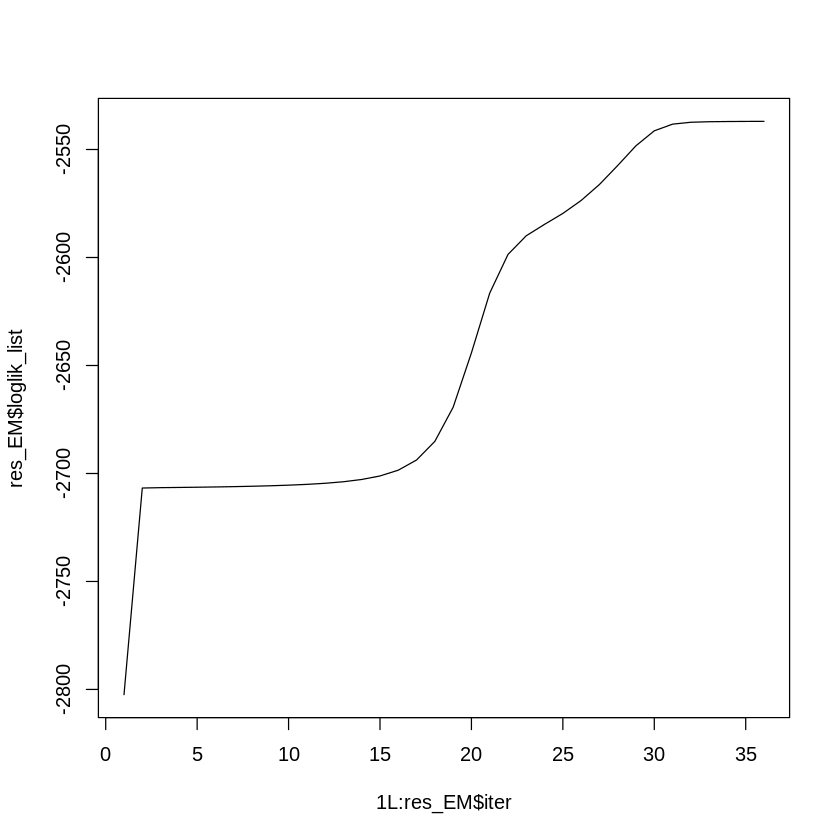

In [11]:
set.seed(1000)
# simulate data with 2:5:3 mixture with N(-5,1), N(0,1), N(5,2)
sim_dat <- simul.dat(1000,mu_vec=c(-5,0,5),sigma_vec=c(1,1,2),pi_vec=c(0.2,0.5,0.3))
EM <- normMixEm$new(input_dat = sim_dat,num_components = 3L)
print(res_EM <- EM$run.EM(loglik_tol=1e-5))
plot(1L:res_EM$iter,res_EM$loglik_list,type="l")